In [1]:
%matplotlib inline

import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


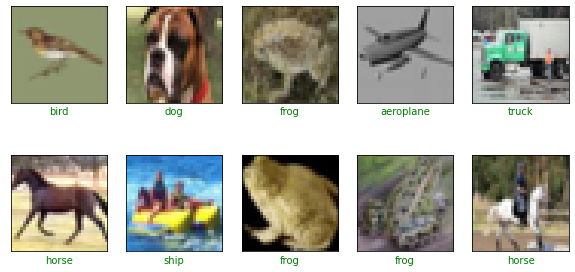

In [3]:
class_names = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

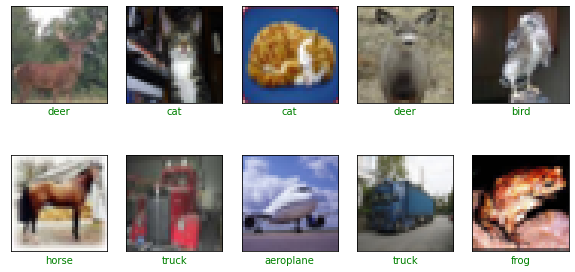

In [4]:
show_random_examples(x_test, y_test, y_test)

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        1

In [6]:
%%time

h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=20, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/20
391/391 [==============================] - 24s 34ms/step - loss: 1.4748 - accuracy: 0.4752 - val_loss: 2.1452 - val_accuracy: 0.3302
Epoch 2/20
391/391 [==============================] - 12s 32ms/step - loss: 1.0152 - accuracy: 0.6390 - val_loss: 1.0150 - val_accuracy: 0.6455
Epoch 3/20
391/391 [==============================] - 12s 32ms/step - loss: 0.8446 - accuracy: 0.7044 - val_loss: 0.8307 - val_accuracy: 0.7108
Epoch 4/20
391/391 [==============================] - 13s 33ms/step - loss: 0.7434 - accuracy: 0.7371 - val_loss: 0.9706 - val_accuracy: 0.6906
Epoch 5/20
391/391 [==============================] - 12s 32ms/step - loss: 0.6745 - accuracy: 0.7649 - val_loss: 0.8514 - val_accuracy: 0.7219
Epoch 6/20
391/391 [==============================] - 13s 33ms/step - loss: 0.6209 - accuracy: 0.7828 - val_loss: 0.7483 - val_accuracy: 0.7486
Epoch 7/20
391/391 [==============================] - 12s 32ms/step - loss: 0.5741 - accuracy: 0.7970 - val_loss: 0.6369 - val_accuracy:

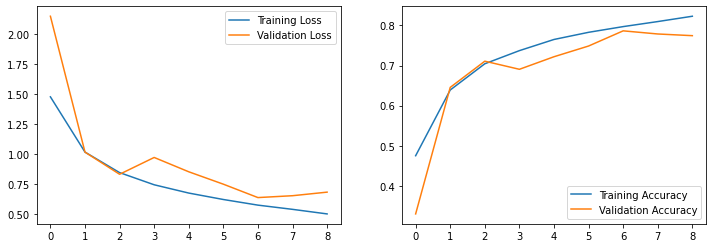

In [7]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [9]:
model = tf.keras.models.load_model('models/model_0.786.h5')
preds = model.predict(x_test/255.)

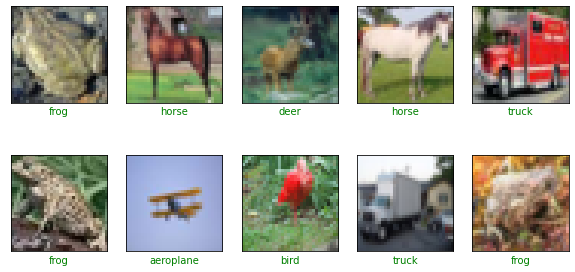

In [10]:
show_random_examples(x_test, y_test, preds)